In [145]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [146]:
url = "https://raw.githubusercontent.com/alexeygrigorev/datasets/master/course_lead_scoring.csv"
df = pd.read_csv(url)
df.head()

,lead_source,industry,number_of_courses_viewed,annual_income,employment_status,location,interaction_count,lead_score,converted
0,paid_ads,NaN,1,79450.0,unemployed,south_america,4,0.94,1
1,social_media,retail,1,46992.0,employed,south_america,1,0.80,0
2,events,healthcare,5,78796.0,unemployed,australia,3,0.69,1
3,paid_ads,retail,2,83843.0,NaN,australia,1,0.87,0
4,referral,education,3,85012.0,self_employed,europe,3,0.62,1


# Data preparation

In [147]:
df.dtypes

lead_source                  object
industry                     object
number_of_courses_viewed      int64
annual_income               float64
employment_status            object
location                     object
interaction_count             int64
lead_score                  float64
converted                     int64
dtype: object

In [148]:
df.isna().sum()

lead_source                 128
industry                    134
number_of_courses_viewed      0
annual_income               181
employment_status           100
location                     63
interaction_count             0
lead_score                    0
converted                     0
dtype: int64

In [149]:
categorical = df.select_dtypes(include=['object']).columns
numerical = df.select_dtypes(include=['int64', 'float64']).columns

In [150]:
df[categorical].fillna('NA', inplace=True)
df[numerical].fillna(0.0, inplace=True)

C:\Users\LOQ 15\AppData\Local\Temp\ipykernel_17768\3182191308.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[categorical].fillna('NA', inplace=True)
C:\Users\LOQ 15\AppData\Local\Temp\ipykernel_17768\3182191308.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[numerical].fillna(0.0, inplace=True)


# Q1

In [151]:
df.industry.mode()[0]

'retail'

# Q2

<Axes: >

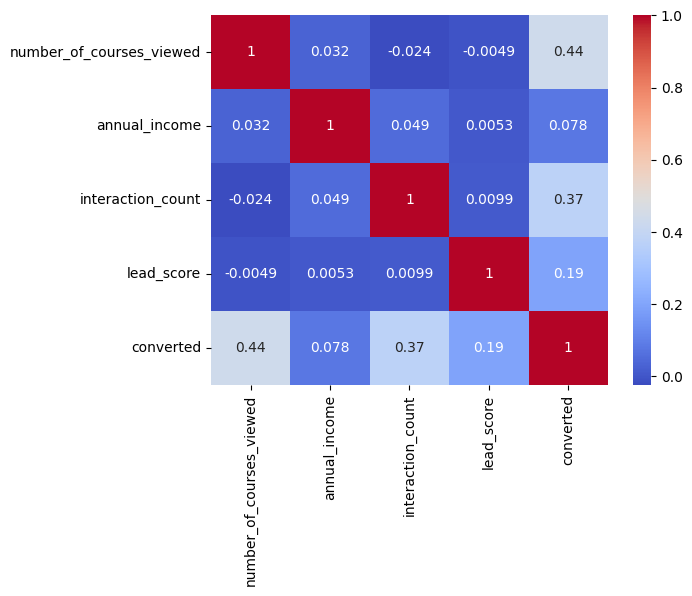

In [152]:
import seaborn as sns
corr_matrix = df.corr(numeric_only=True)
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')

annual_income and interaction_count

# Q2    

In [153]:
target = 'y'


In [154]:
from sklearn.model_selection import train_test_split
df_train_full, df_test = train_test_split(df, test_size=0.2, random_state=42)
df_train, df_val = train_test_split(df_train_full, test_size=0.25, random_state=42)

In [155]:
y_train = df_train['converted'].values
y_val = df_val['converted'].values
y_test = df_test['converted'].values

In [156]:
df_train = df_train.drop(columns=['converted']).reset_index(drop=True)
df_val = df_val.drop(columns=['converted']).reset_index(drop=True)
df_test = df_test.drop(columns=['converted']).reset_index(drop=True)

# Q3

In [157]:
from sklearn.metrics import mutual_info_score

# Fill missing values for categorical and numerical columns
df_mi = df_train_full.copy()
df_mi[categorical] = df_mi[categorical].fillna('NA')
df_mi[numerical.drop('converted')] = df_mi[numerical.drop('converted')].fillna(0.0)

def compute_mi(series):
    return mutual_info_score(series, df_mi['converted'])

mi = df_mi.drop(columns=['converted']).apply(compute_mi)
mi = mi.sort_values(ascending=False)
mi

C:\Users\LOQ 15\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\cluster\_supervised.py:49: UserWarning: The number of unique classes is greater than 50% of the number of samples. `y` could represent a regression problem, not a classification problem.
  type_label = type_of_target(labels_true)
C:\Users\LOQ 15\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and binary values for target
  warnings.warn(msg, UserWarning)


annual_income               0.581609
number_of_courses_viewed    0.121089
interaction_count           0.083195
lead_score                  0.068899
lead_source                 0.025665
employment_status           0.013258
industry                    0.011685
location                    0.002253
dtype: float64

# Q4

In [158]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# one-hot encode and align
X_train = pd.get_dummies(df_train, drop_first=True)
X_val = pd.get_dummies(df_val, drop_first=True)
X_train, X_val = X_train.align(X_val, join='left', axis=1, fill_value=0)

# Fill missing values with 0
X_train = X_train.fillna(0)
X_val = X_val.fillna(0)

model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000, random_state=42)
model.fit(X_train.values, y_train)

acc = accuracy_score(y_val, model.predict(X_val.values))
print("Validation accuracy (rounded to 2):", round(acc, 2))

Validation accuracy (rounded to 2): 0.7


# Q5

In [161]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# features to test
features_to_test = ['industry', 'employment_status', 'lead_score']

# baseline with all features (one-hot encoded)
X_train_all = pd.get_dummies(df_train, drop_first=True)
X_val_all = pd.get_dummies(df_val, drop_first=True)
X_train_all, X_val_all = X_train_all.align(X_val_all, join='left', axis=1, fill_value=0)
X_train_all = X_train_all.fillna(0)
X_val_all = X_val_all.fillna(0)

model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000, random_state=42)
model.fit(X_train_all.values, y_train)
acc_orig = accuracy_score(y_val, model.predict(X_val_all.values))

results = {}
for feat in features_to_test:
    if feat not in df_train.columns:
        print(f"Feature '{feat}' not found in df_train — skipping")
        continue

    # drop original column (categorical or numeric) before one-hot encoding
    X_train_tmp = df_train.drop(columns=[feat])
    X_val_tmp = df_val.drop(columns=[feat])

    X_train_tmp = pd.get_dummies(X_train_tmp, drop_first=True)
    X_val_tmp = pd.get_dummies(X_val_tmp, drop_first=True)
    X_train_tmp, X_val_tmp = X_train_tmp.align(X_val_tmp, join='left', axis=1, fill_value=0)
    X_train_tmp = X_train_tmp.fillna(0)
    X_val_tmp = X_val_tmp.fillna(0)

    model_tmp = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000, random_state=42)
    model_tmp.fit(X_train_tmp.values, y_train)
    acc_tmp = accuracy_score(y_val, model_tmp.predict(X_val_tmp.values))

    diff = acc_orig - acc_tmp
    results[feat] = {'acc_without': acc_tmp, 'diff': diff, 'abs_diff': abs(diff)}

# print results
print(f"Baseline accuracy (all features): {acc_orig:.6f}\n")
for feat, info in results.items():
    print(f"{feat:20s} acc_without={info['acc_without']:.6f}  diff={info['diff']:.6f}")

# least useful = smallest absolute difference
if results:
    least_useful = min(results.items(), key=lambda x: x[1]['abs_diff'])[0]
    print("\nLeast useful feature (smallest abs diff):", least_useful)


Baseline accuracy (all features): 0.699659

industry             acc_without=0.699659  diff=0.000000
employment_status    acc_without=0.696246  diff=0.003413
lead_score           acc_without=0.692833  diff=0.006826

Least useful feature (smallest abs diff): industry


# Q6

In [162]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# prepare one-hot features and align (same as Q4)
X_train = pd.get_dummies(df_train, drop_first=True)
X_val = pd.get_dummies(df_val, drop_first=True)
X_train, X_val = X_train.align(X_val, join='left', axis=1, fill_value=0)
X_train = X_train.fillna(0)
X_val = X_val.fillna(0)

Cs = [0.01, 0.1, 1, 10, 100]
results = []

for C in Cs:
    model = LogisticRegression(solver='liblinear', C=C, max_iter=1000, random_state=42)
    model.fit(X_train.values, y_train)
    acc = accuracy_score(y_val, model.predict(X_val.values))
    results.append((C, acc))
    print(f"C={C:<6}  acc={acc:.6f}  acc_rounded={round(acc,3):.3f}")

# choose best C (if tie, pick smallest C)
best_acc = max(r[1] for r in results)
best_cs = [r[0] for r in results if r[1] == best_acc]
best_C = min(best_cs)
print("\nBest C:", best_C, "validation accuracy (rounded to 3):", round(best_acc, 3))

C=0.01    acc=0.696246  acc_rounded=0.696
C=0.1     acc=0.699659  acc_rounded=0.700
C=1       acc=0.699659  acc_rounded=0.700
C=10      acc=0.699659  acc_rounded=0.700
C=100     acc=0.699659  acc_rounded=0.700

Best C: 0.1 validation accuracy (rounded to 3): 0.7
